# Zadanie 0.

In [19]:
%matplotlib inline

import io
import random
import zipfile

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import skimage
from sklearn.datasets import load_iris

sns.set_style('whitegrid')
iris = load_iris()

In [39]:
def euclidean_distance(X, Y):  # X -> points, Y -> centroids
    print('minus two dot product')
    dists = -2 * (X @ Y.T)
    print('dot prod done')
    print('sum of Y square')
    dists += np.sum(Y ** 2, axis=1)
    print('Y square done')
    print('sum of X square')
    dists += np.sum(X ** 2, axis=1)[:, np.newaxis]
    print('X square done')

    return np.abs(dists)

In [27]:
def k_means(data, how_many_groups, distance_func, return_centroids=False):
    data_len = len(data)
    centroids_idx = set()

    # for uniqueness sake
    while len(centroids_idx) != how_many_groups:
        centroids_idx = {np.random.randint(data_len) for _ in range(how_many_groups)}
    centroids = data[list(centroids_idx)]
    
    prev_group_mapping = np.array([42])
    curr_group_mapping = np.array([44])
    
    while not np.array_equal(prev_group_mapping, curr_group_mapping):
        print('new iteration')
        # reassign objects to centroids...
        print('doing distance')
        distance_matrix = distance_func(data, centroids)
        print('distance done')
        print('doing mapping')
        new_group_mapping = np.argsort(distance_matrix)[:, 0]
        prev_group_mapping = curr_group_mapping
        curr_group_mapping = new_group_mapping
        print('mapping done')
        # ... then recalculate the centroids
        #print('recalculating centroids')
        centroids = np.array([
            np.sum(group_members := data[curr_group_mapping == group_idx], 0)
            / (group_members.shape[0] or 1)  # to avoid dividing by zero
            for group_idx in range(how_many_groups)
        ])
        #print('centroids done')

    if return_centroids:
        return curr_group_mapping, centroids
    return curr_group_mapping

In [188]:
GROUPS_COUNT = 3

grouping = k_means(iris.data, GROUPS_COUNT, euclidean_distance)
cluster_names = np.array([f'Cluster #{idx}' for idx in range(GROUPS_COUNT)])

iris_df = pd.DataFrame(iris.data)
iris_df.columns = iris.feature_names
iris_df['target'] = iris.target
iris_df['cluster'] = grouping

iris_df = iris_df.assign(target=iris.target_names[iris_df['target']])
iris_df = iris_df.assign(cluster=cluster_names[iris_df['cluster']])

iris_df

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

        target     cluster  
0       setosa  Cluster #2  
1       setosa  Cluster #2  
2       setosa  Cluster #2  
3       setosa  Cluster #2  
4       setosa  Cluster #2  
..         ...         ...  
145  virginica  Cluster #0  
146  virginica  Cluster #1  
147  virginica  Cluster #0  
148  virginica  Cluster #0  
149  virginica  Cluster #1  

[150 rows x 6 columns]

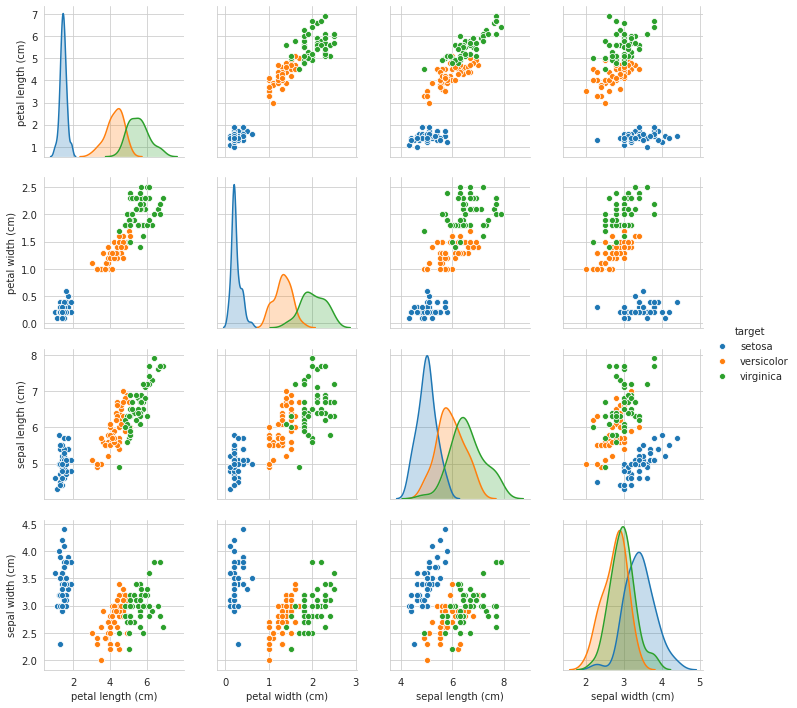

In [183]:
sns.pairplot(iris_df[set(iris_df.columns) - {'cluster'}], hue='target')

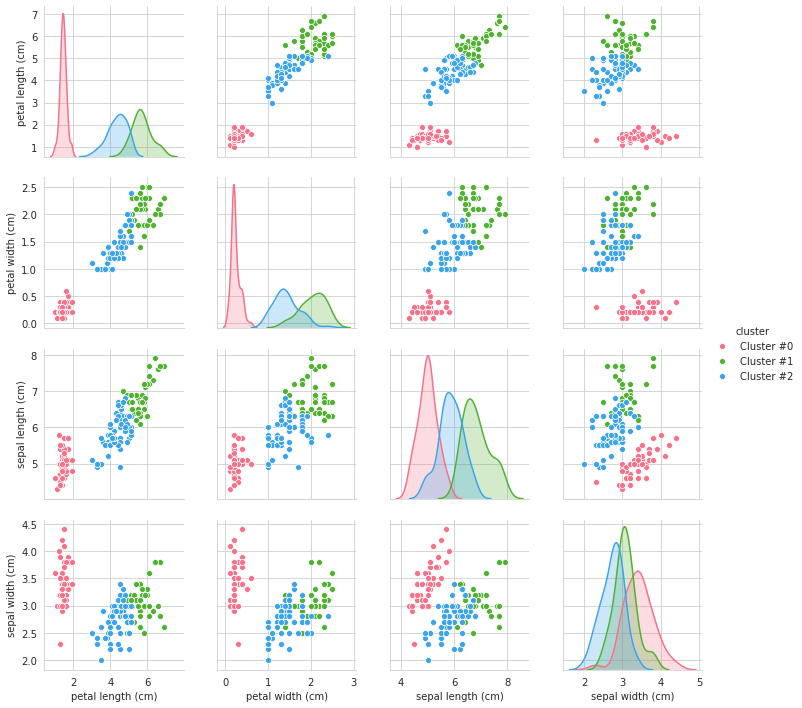

In [185]:
sns.pairplot(iris_df[set(iris_df.columns) - {'target'}], hue='cluster', palette='husl')

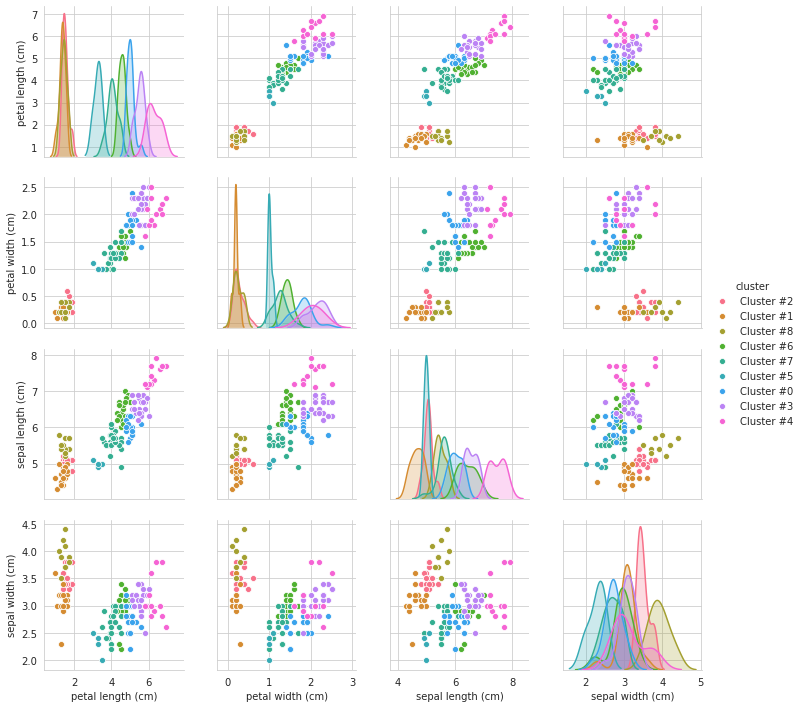

In [187]:
sns.pairplot(iris_df[set(iris_df.columns) - {'target'}], hue='cluster', palette='husl')

# Zadanie 1.

In [5]:
def generate_vectors(samples, dimensions, dists, dist_probs, mus, sigmas, dtype='float64'):
    print('mapping to probs')
    sample_to_prob_mapping = np.array(
        random.choices(range(dists), k=samples, weights=dist_probs), dtype=f'int{dtype[-2:]}')
    print('mapping done')
    # an array of N vectors taken from GAUSS(0, 1)
    print('generating randvars')
    rand_vars = np.random.randn(samples, dimensions)
    print('generating done')
    print('doing cholesky')
    covariance_cholesky_left = np.linalg.cholesky(sigmas)
    print('cholesky done')
    # then, we take an appropriate 'mu' and do the calculation,
    # as shown on the lecture
    # TODO: can it be vectorized?
    return np.array([
        mus[sample_to_prob_mapping[idx]] \
            + covariance_cholesky_left[sample_to_prob_mapping[idx]] @ rand_vars[idx]
        for idx in range(samples)
    ], dtype=dtype)

In [30]:
N, d, K = 5_000, 2, 5
p = np.ones(K) / K
Mu = 3 * np.ones((1, d)) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)

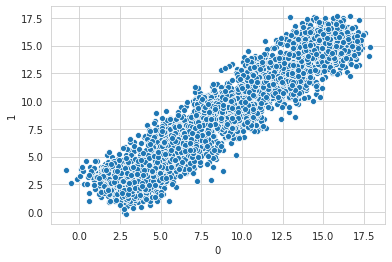

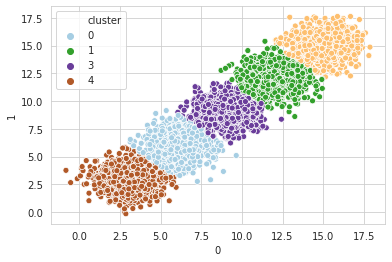

In [31]:
a = pd.DataFrame(generate_vectors(N, d, K, p, Mu, Sigma))
sns.scatterplot(a[0], a[1])
plt.show()

a_clusters = k_means(a.to_numpy(), K, euclidean_distance)
a['cluster'] = a_clusters
sns.scatterplot(x=0, y=1, hue='cluster', palette='Paired', data=a)
plt.show()

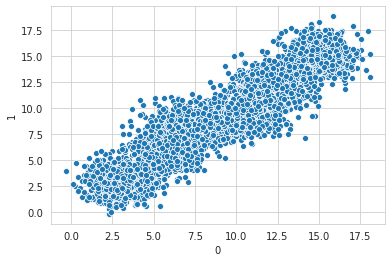

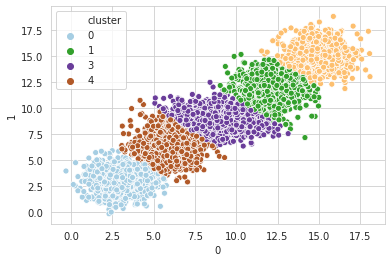

In [266]:
Sigma[2] = np.array([
    [3, 0],
    [0, 1]
])

b = pd.DataFrame(generate_vectors(N, d, K, p, Mu, Sigma))
sns.scatterplot(b[0], b[1])
plt.show()

b_clusters = k_means(b.to_numpy(), K, euclidean_distance)
b['cluster'] = b_clusters
sns.scatterplot(x=0, y=1, hue='cluster', palette='Paired', data=b)
plt.show()

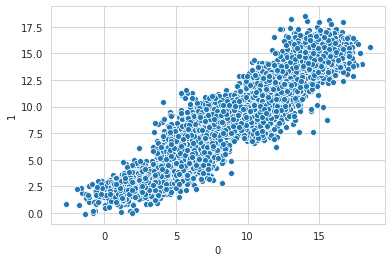

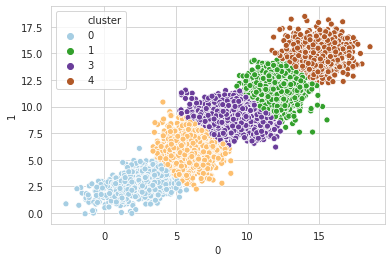

In [267]:
Sigma[0] = np.array([
    [3, 1],
    [1, 1]
])

c = pd.DataFrame(generate_vectors(N, d, K, p, Mu, Sigma))
sns.scatterplot(c[0], c[1])
plt.show()

c_clusters = k_means(c.to_numpy(), K, euclidean_distance)
c['cluster'] = c_clusters
sns.scatterplot(x=0, y=1, hue='cluster', palette='Paired', data=c)
plt.show()

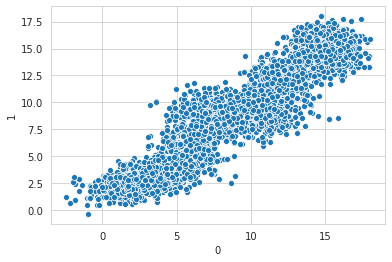

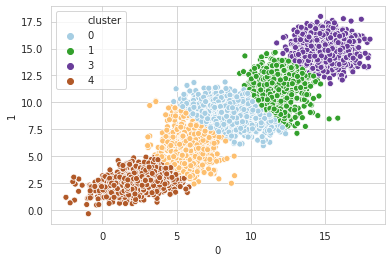

In [274]:
p = np.array([0.2, 0.1, 0.3, 0.1, 0.3])
task_d = pd.DataFrame(generate_vectors(N, d, K, p, Mu, Sigma))
sns.scatterplot(task_d[0], task_d[1])
plt.show()

task_d_clusters = k_means(task_d.to_numpy(), K, euclidean_distance)
task_d['cluster'] = task_d_clusters
sns.scatterplot(x=0, y=1, hue='cluster', palette='Paired', data=task_d)
plt.show()

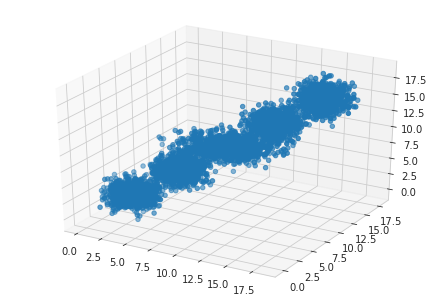

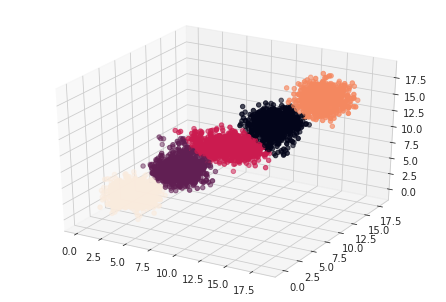

In [289]:
N, d, K = 5_000, 3, 5
p = np.ones(K) / K
Mu = 3 * np.ones((1, d)) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)

Sigma[2] = np.array([
    [3, 1, 0],
    [1, 1, 0],
    [0, 0, 1]
])

e = pd.DataFrame(generate_vectors(N, d, K, p, Mu, Sigma))

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(e[0], e[1], e[2], marker='o')
plt.show()

e_clusters = k_means(e.to_numpy(), K, euclidean_distance)
e['cluster'] = e_clusters

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(e[0], e[1], e[2], c=e['cluster'])
plt.show()

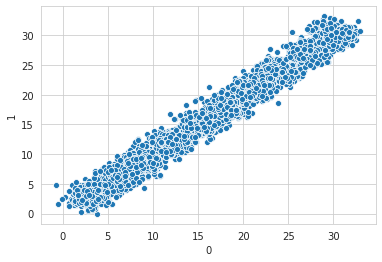

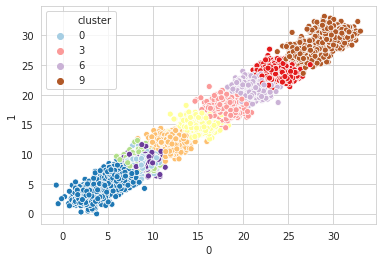

In [8]:
N, d, K = 5_000, 100, 10
p = np.ones(K) / K
Mu = 3 * np.ones((1, d)) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)


f = pd.DataFrame(generate_vectors(N, d, K, p, Mu, Sigma))
sns.scatterplot(f[0], f[1])
plt.show()

f_clusters = k_means(f.to_numpy(), K, euclidean_distance)
f['cluster'] = f_clusters
sns.scatterplot(x=0, y=1, hue='cluster', palette='Paired', data=f)
plt.show()

# Zadanie 2.

mapping to probs
mapping done
generating randvars
generating done
doing cholesky
cholesky done


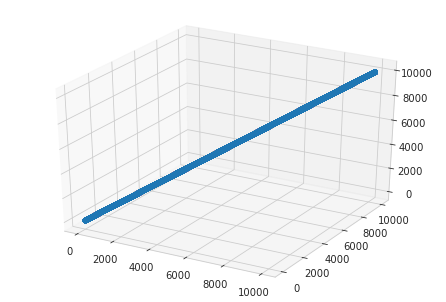

new iteration
doing distance
minus two dot product
dot prod done
sum of Y square
Y square done
sum of X square
X square done
distance done
doing mapping
mapping done
recalculating centroids
centroids done
new iteration
doing distance
minus two dot product


In [ ]:
N, d, K = 100_000, 100, 1_000
p = np.ones(K) / K
Mu = 10 * np.ones((1, d)) * np.arange(1, K + 1)[:, np.newaxis]
#Sigma = np.repeat(np.eye(d, dtype='int16'), K)
Sigma = np.zeros((K, d, d)) + np.eye(d)

vectors = pd.DataFrame(generate_vectors(N, d, K, p, Mu, Sigma))

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(vectors[0], vectors[1], vectors[2], marker='o')
plt.show()

vectors_clusters = k_means(vectors.to_numpy(), K, euclidean_distance)
vectors['cluster'] = vectors_clusters

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(vectors[0], vectors[1], vectors[2], c=vectors['cluster'])
plt.show()

# Zadanie 3.

In [8]:
iris_df = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    names=['sepal_length', 'sepal_width', 'petal_length', 'petal_with', 'species'])

iris_df

sepal_length  sepal_width  petal_length  petal_with         species
0             5.1          3.5           1.4         0.2     Iris-setosa
1             4.9          3.0           1.4         0.2     Iris-setosa
2             4.7          3.2           1.3         0.2     Iris-setosa
3             4.6          3.1           1.5         0.2     Iris-setosa
4             5.0          3.6           1.4         0.2     Iris-setosa
..            ...          ...           ...         ...             ...
145           6.7          3.0           5.2         2.3  Iris-virginica
146           6.3          2.5           5.0         1.9  Iris-virginica
147           6.5          3.0           5.2         2.0  Iris-virginica
148           6.2          3.4           5.4         2.3  Iris-virginica
149           5.9          3.0           5.1         1.8  Iris-virginica

[150 rows x 5 columns]

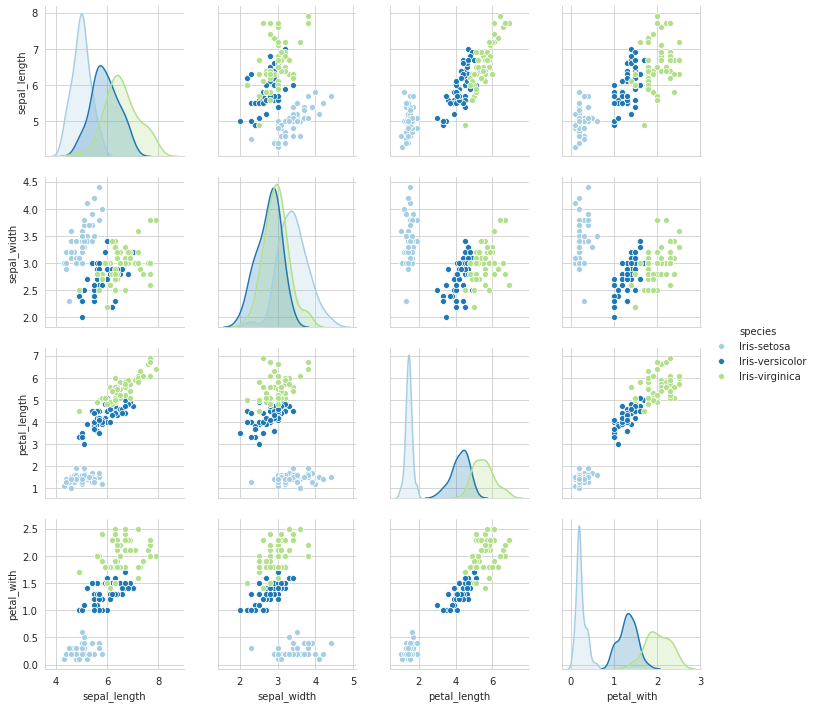

In [10]:
sns.pairplot(iris_df, hue='species', palette='Paired')

In [65]:
wine_df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    names=['Cultivar', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 
           'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 
           'Proanthocyanins', 'Color intensity', 'Hue',
           'OD280/OD315 of diluted wines', 'Proline'])
cultivar_names = np.array(['JUST-A-PLACEHOLDER'] + [f'Cultivar #{_}' for _ in range(1, 3+1)])
wine_df = wine_df.assign(Cultivar=cultivar_names[wine_df['Cultivar']])

wine_df

Cultivar  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
0    Cultivar #1    14.23        1.71  2.43               15.6        127   
1    Cultivar #1    13.20        1.78  2.14               11.2        100   
2    Cultivar #1    13.16        2.36  2.67               18.6        101   
3    Cultivar #1    14.37        1.95  2.50               16.8        113   
4    Cultivar #1    13.24        2.59  2.87               21.0        118   
..           ...      ...         ...   ...                ...        ...   
173  Cultivar #3    13.71        5.65  2.45               20.5         95   
174  Cultivar #3    13.40        3.91  2.48               23.0        102   
175  Cultivar #3    13.27        4.28  2.26               20.0        120   
176  Cultivar #3    13.17        2.59  2.37               20.0        120   
177  Cultivar #3    14.13        4.10  2.74               24.5         96   

     Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0             2.80        3.06                  0.28             2.29   
1             2.65        2.76                  0.26             1.28   
2             2.80        3.24                  0.30             2.81   
3             3.85        3.49                  0.24             2.18   
4             2.80        2.69                  0.39             1.82   
..             ...         ...                   ...              ...   
173           1.68        0.61                  0.52             1.06   
174           1.80        0.75                  0.43             1.41   
175           1.59        0.69                  0.43             1.35   
176           1.65        0.68                  0.53             1.46   
177           2.05        0.76                  0.56             1.35   

     Color intensity   Hue  OD280/OD315 of diluted wines  Proline  
0               5.64  1.04                          3.92     1065  
1               4.38  1.05                          3.40     1050  
2               5.68  1.03                          3.17     1185  
3               7.80  0.86                          3.45     1480  
4               4.32  1.04                          2.93      735  
..               ...   ...                           ...      ...  
173             7.70  0.64                          1.74      740  
174             7.30  0.70                          1.56      750  
175            10.20  0.59                          1.56      835  
176             9.30  0.60                          1.62      840  
177             9.20  0.61                          1.60      560  

[178 rows x 14 columns]

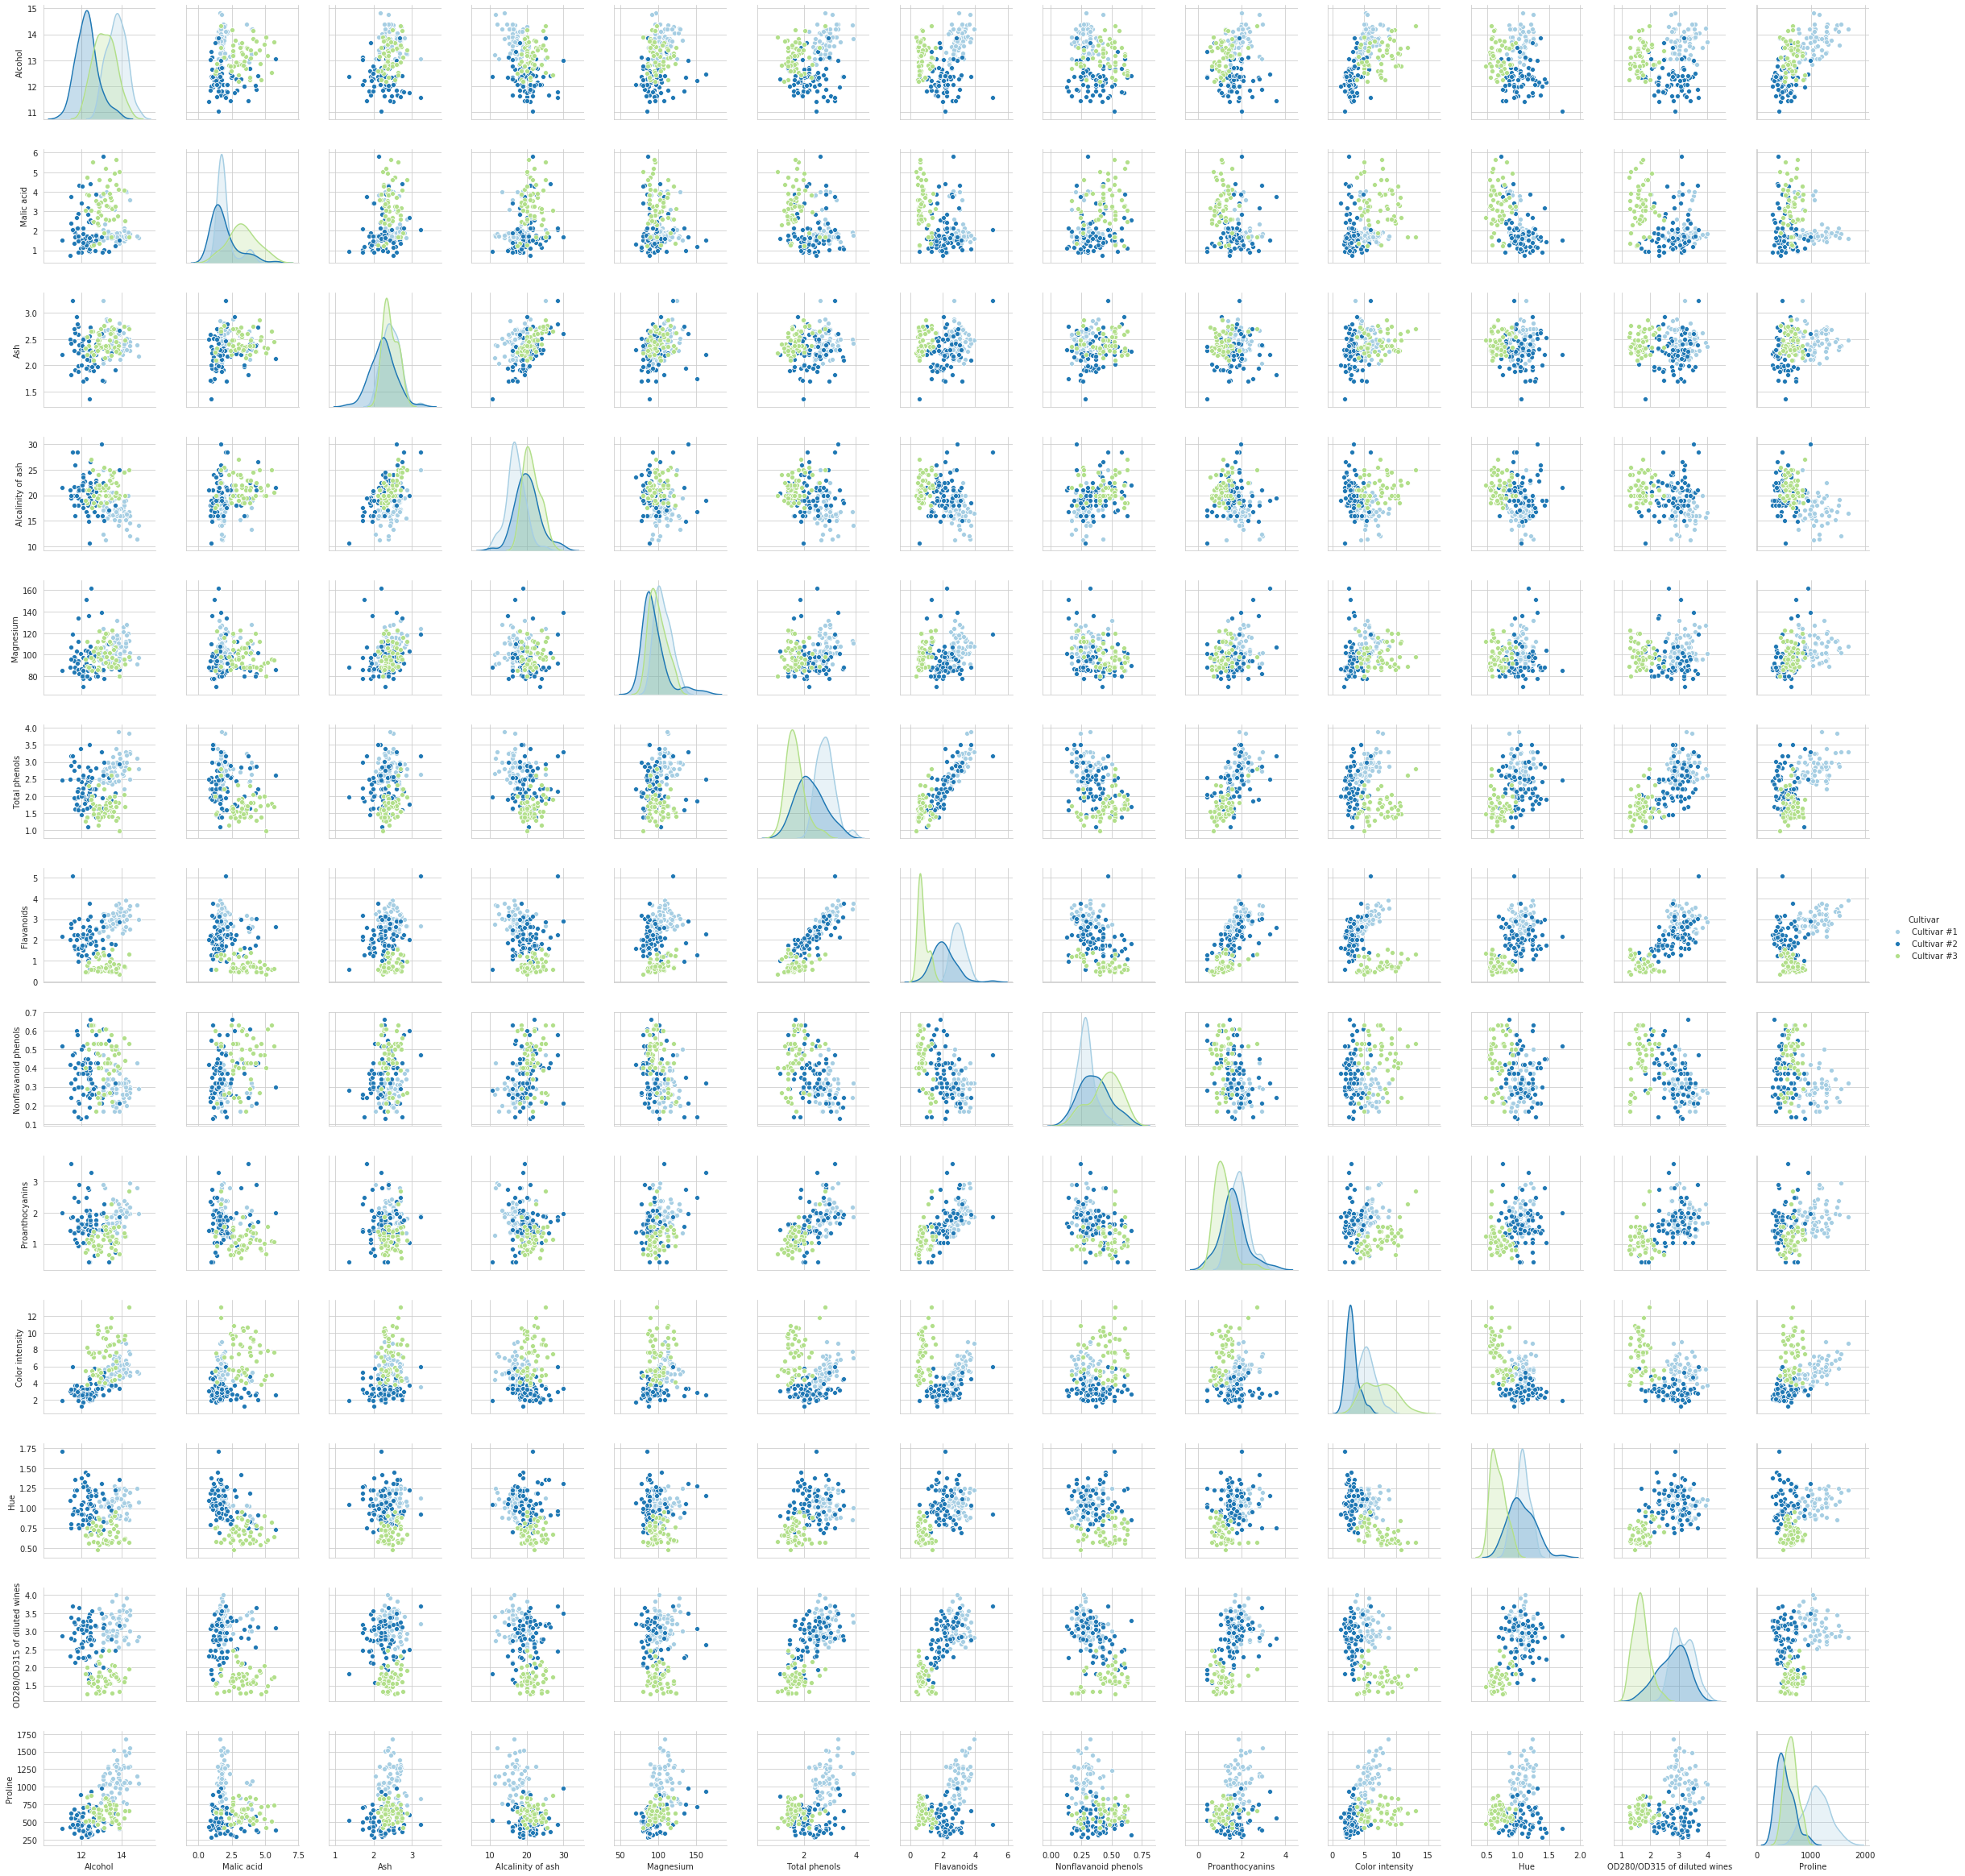

In [22]:
sns.pairplot(wine_df, hue='Cultivar', palette='Paired')

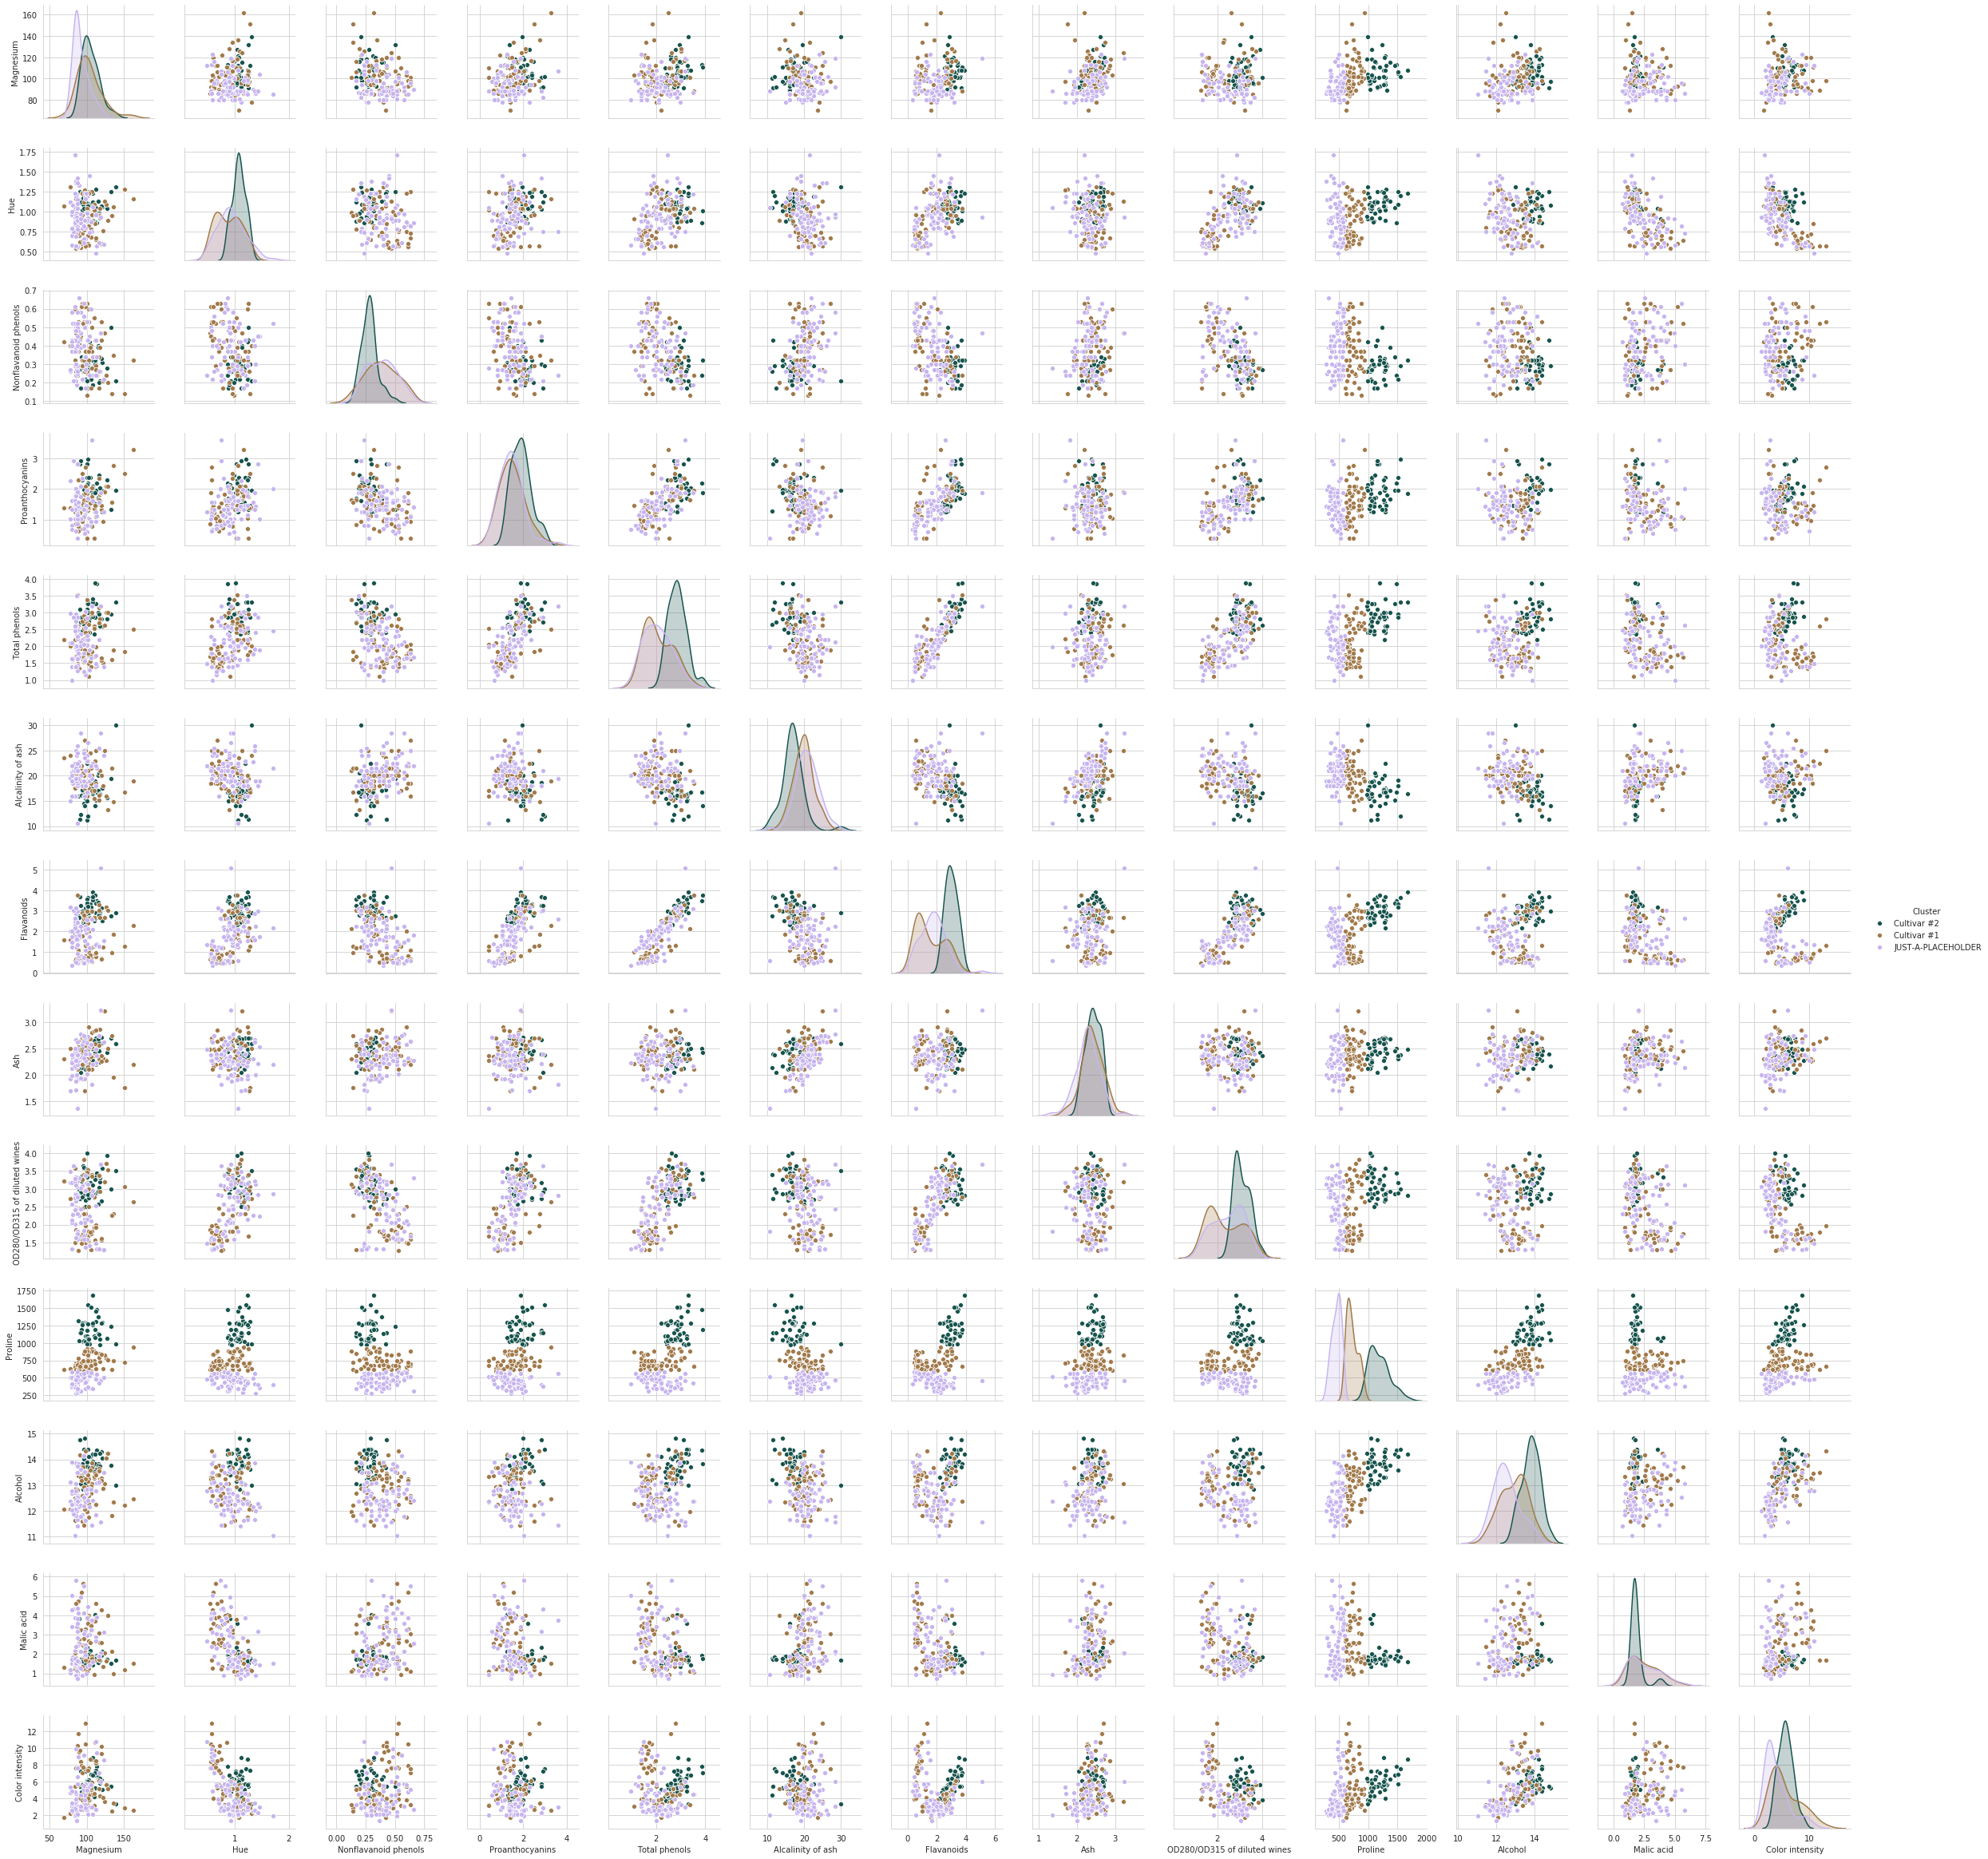

In [66]:
wine_clusters = k_means(
    wine_df[set(wine_df.columns) - {'Cultivar'}].to_numpy(), 3, euclidean_distance)
wine_df = wine_df.assign(Cluster=cultivar_names[wine_clusters])

sns.pairplot(wine_df[set(wine_df.columns) - {'Cultivar'}], hue='Cluster', palette='cubehelix')

In [78]:
haberman_df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data',
    names=['age', 'operation_year', 'affected_lymph_nodes', 'outcome'])

possible_outcomes = np.array(['counting-from-one', 'ALIVE', 'DEAD'])
haberman_df = haberman_df.assign(
    outcome=possible_outcomes[haberman_df['outcome']])

haberman_df

age  operation_year  affected_lymph_nodes outcome
0     30              64                     1   ALIVE
1     30              62                     3   ALIVE
2     30              65                     0   ALIVE
3     31              59                     2   ALIVE
4     31              65                     4   ALIVE
..   ...             ...                   ...     ...
301   75              62                     1   ALIVE
302   76              67                     0   ALIVE
303   77              65                     3   ALIVE
304   78              65                     1    DEAD
305   83              58                     2    DEAD

[306 rows x 4 columns]

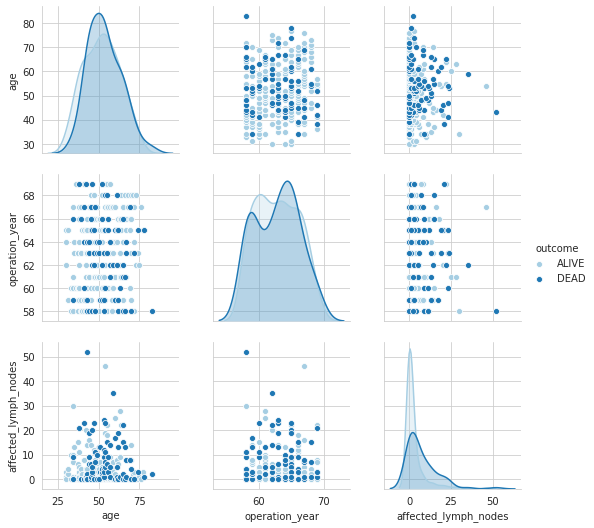

In [74]:
sns.pairplot(haberman_df, hue='outcome', palette='Paired')

In [ ]:
plt.plot()

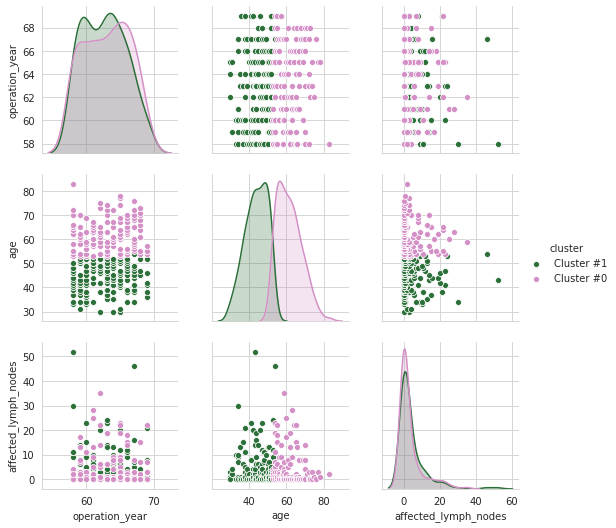

In [79]:
haberman_clusters = k_means(
    haberman_df[set(haberman_df.columns) - {'outcome'}].to_numpy(), 2, euclidean_distance)
haberman_df = haberman_df.assign(
    cluster=np.array([f'Cluster #{_}' for _ in range(2)])[haberman_clusters])

sns.pairplot(haberman_df[set(haberman_df.columns) - {'outcome'}], hue='cluster', palette='cubehelix')

In [96]:
spendings_df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv')
spendings_df = spendings_df[set(spendings_df.columns) - {'Channel', 'Region'}]

spendings_df

Detergents_Paper  Fresh  Grocery   Milk  Delicassen  Frozen
0                2674  12669     7561   9656        1338     214
1                3293   7057     9568   9810        1776    1762
2                3516   6353     7684   8808        7844    2405
3                 507  13265     4221   1196        1788    6404
4                1777  22615     7198   5410        5185    3915
..                ...    ...      ...    ...         ...     ...
435               182  29703    16027  12051        2204   13135
436                93  39228      764   1431        2346    4510
437             14841  14531    30243  15488        1867     437
438               168  10290     2232   1981        2125    1038
439               477   2787     2510   1698          52      65

[440 rows x 6 columns]

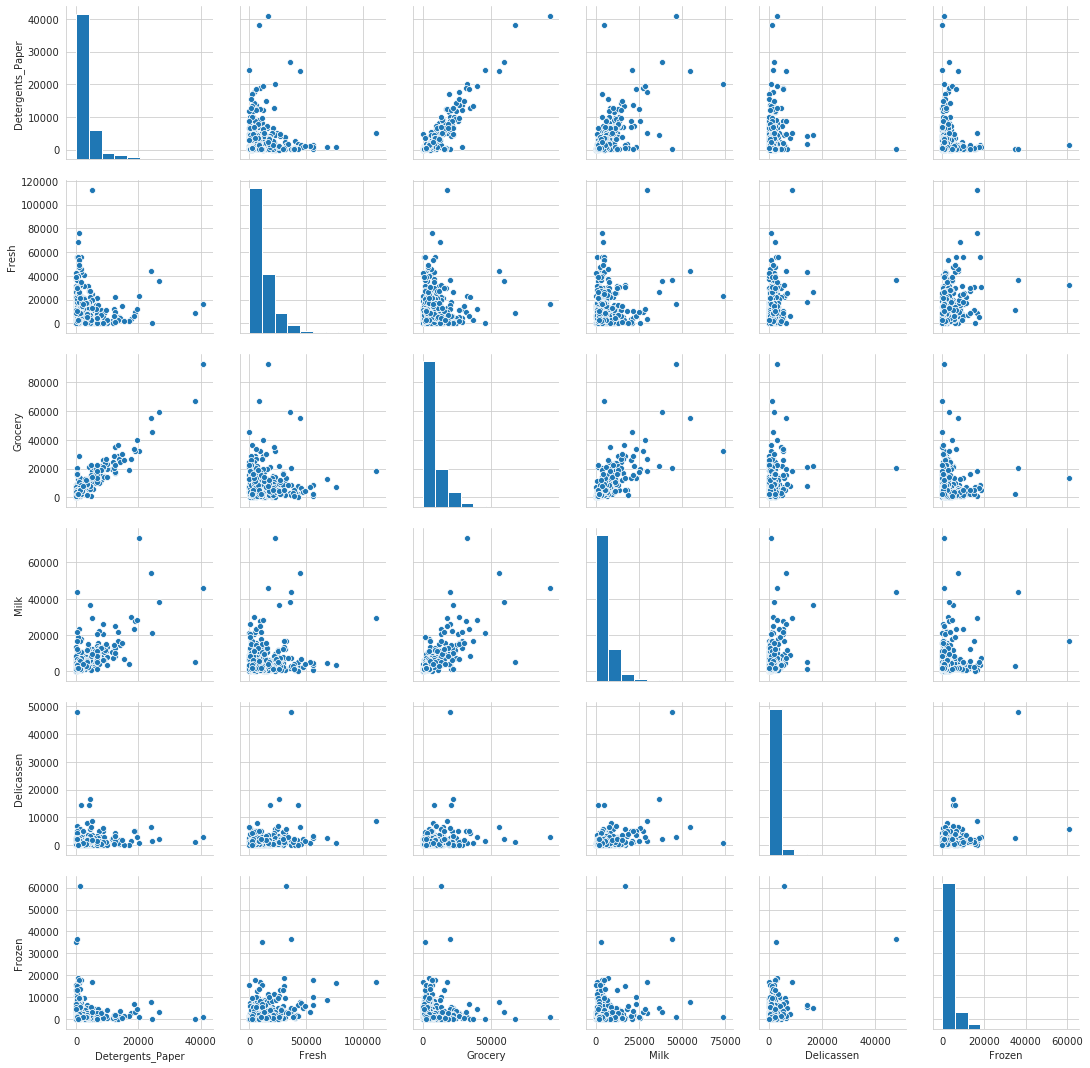

In [87]:
sns.pairplot(spendings_df, palette='cubehelix')

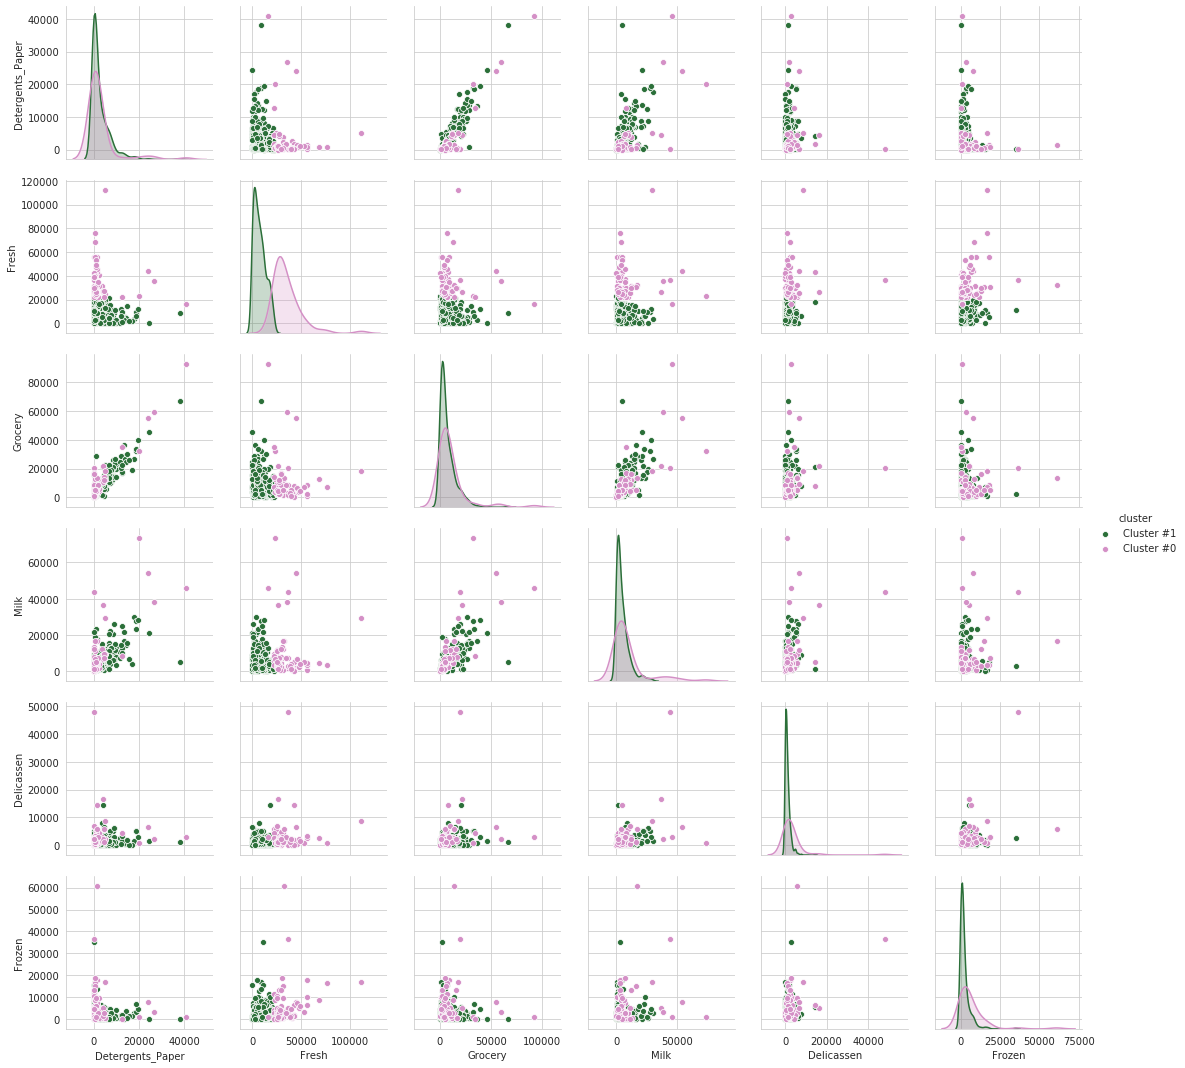

In [88]:
spendings_clusters = k_means(spendings_df.to_numpy(), 2, euclidean_distance)
spendings_df = spendings_df.assign(
    cluster=np.array([f'Cluster #{_}' for _ in range(2)])[spendings_clusters])

sns.pairplot(spendings_df, hue='cluster', palette='cubehelix')

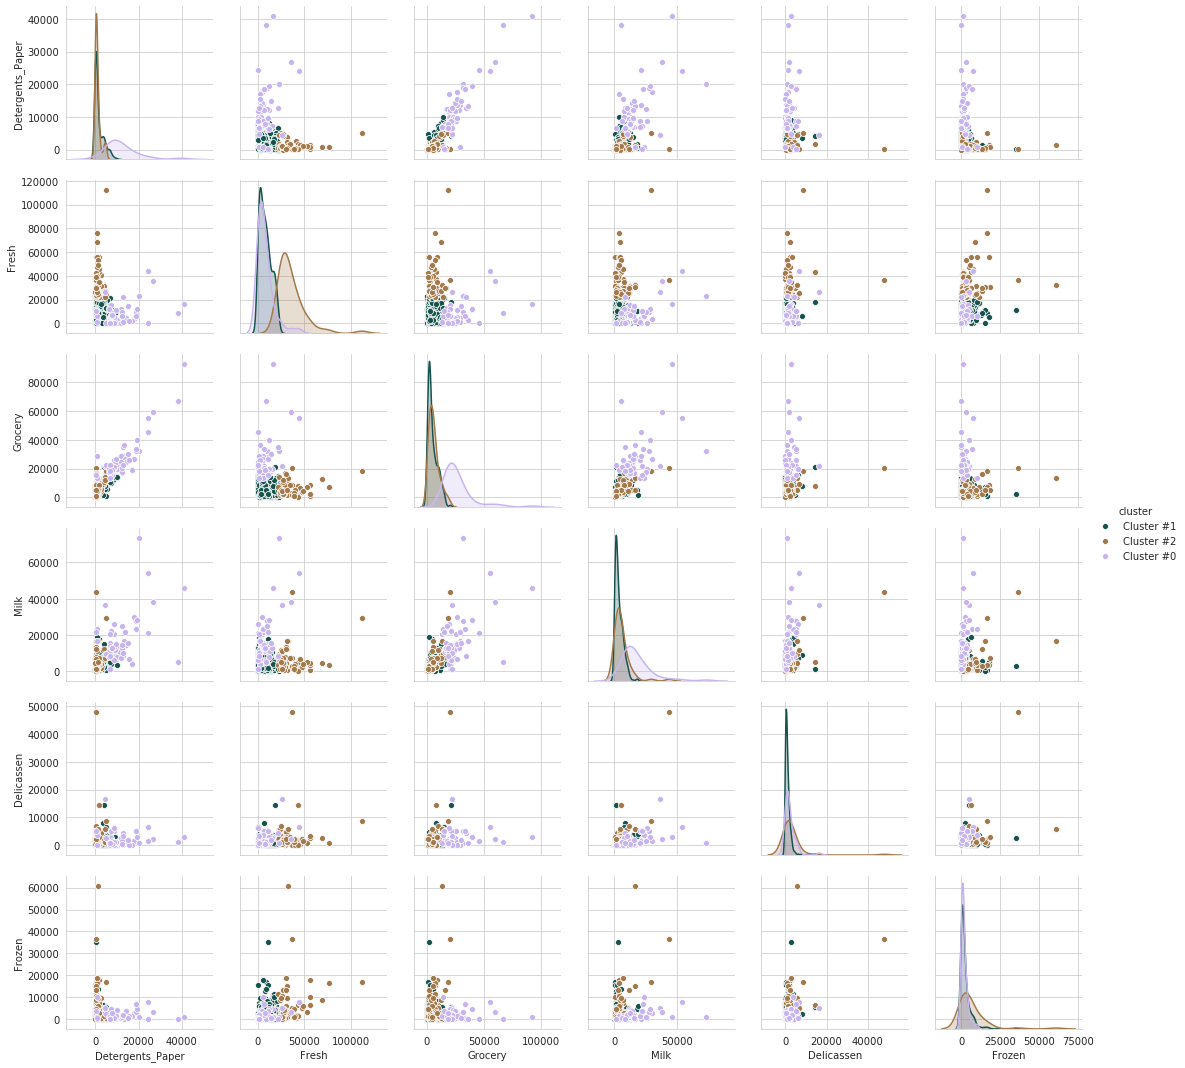

In [93]:
spendings_clusters = k_means(spendings_df.to_numpy(), 3, euclidean_distance)
spendings_df = spendings_df.assign(
    cluster=np.array([f'Cluster #{_}' for _ in range(3)])[spendings_clusters])

sns.pairplot(spendings_df, hue='cluster', palette='cubehelix')

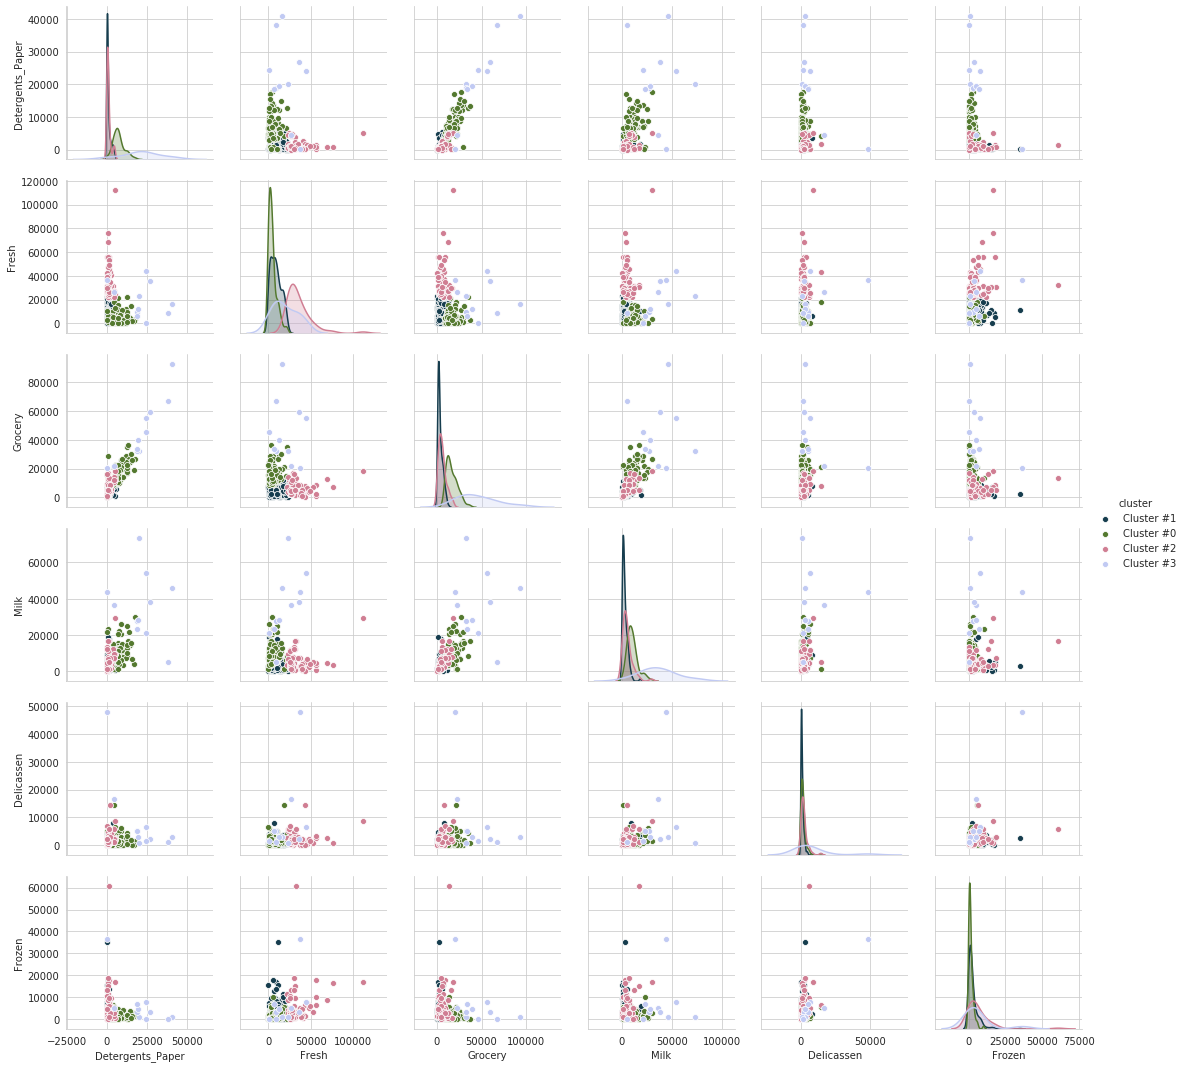

In [95]:
spendings_clusters = k_means(spendings_df.to_numpy(), 4, euclidean_distance)
spendings_df = spendings_df.assign(
    cluster=np.array([f'Cluster #{_}' for _ in range(4)])[spendings_clusters])

sns.pairplot(spendings_df, hue='cluster', palette='cubehelix')

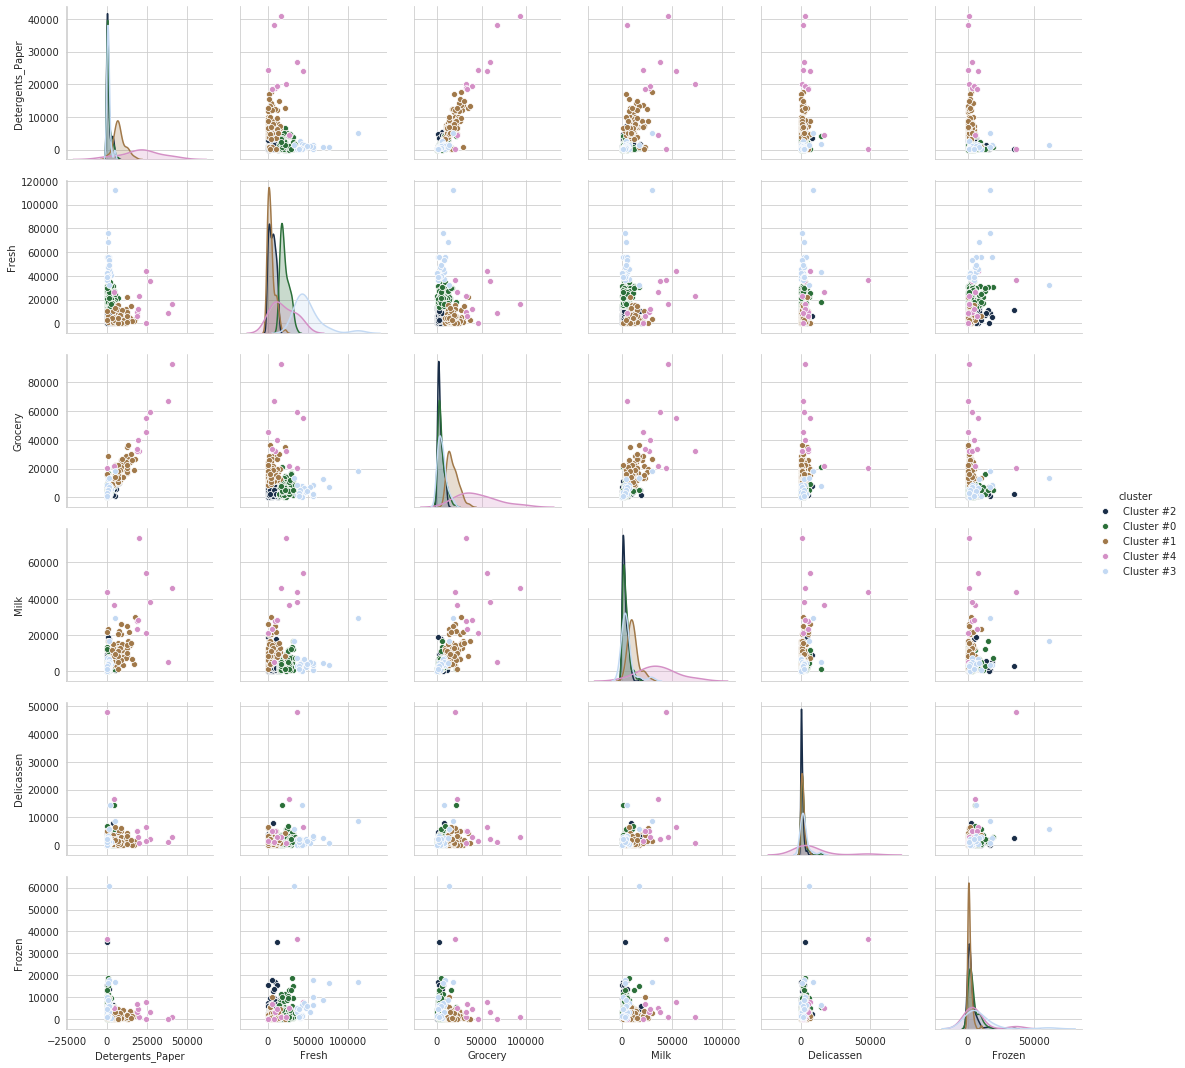

In [97]:
spendings_clusters = k_means(spendings_df.to_numpy(), 5, euclidean_distance)
spendings_df = spendings_df.assign(
    cluster=np.array([f'Cluster #{_}' for _ in range(5)])[spendings_clusters])

sns.pairplot(spendings_df, hue='cluster', palette='cubehelix')

In [135]:
r = requests.get(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip')
with zipfile.ZipFile(io.BytesIO(r.content)).open('datatraining.txt') as occupancy_csv:
    occupancy_df = pd.read_csv(occupancy_csv)
occupancy_df = occupancy_df[set(occupancy_df.columns) - {'date', 'Occupancy'}]

occupancy_df

CO2  Humidity  Light  Temperature  HumidityRatio
1     721.250000   27.2720  426.0        23.18       0.004793
2     714.000000   27.2675  429.5        23.15       0.004783
3     713.500000   27.2450  426.0        23.15       0.004779
4     708.250000   27.2000  426.0        23.15       0.004772
5     704.500000   27.2000  426.0        23.10       0.004757
...          ...       ...    ...          ...            ...
8139  787.250000   36.0975  433.0        21.05       0.005579
8140  789.500000   35.9950  433.0        21.05       0.005563
8141  798.500000   36.0950  433.0        21.10       0.005596
8142  820.333333   36.2600  433.0        21.10       0.005621
8143  821.000000   36.2000  447.0        21.10       0.005612

[8143 rows x 5 columns]

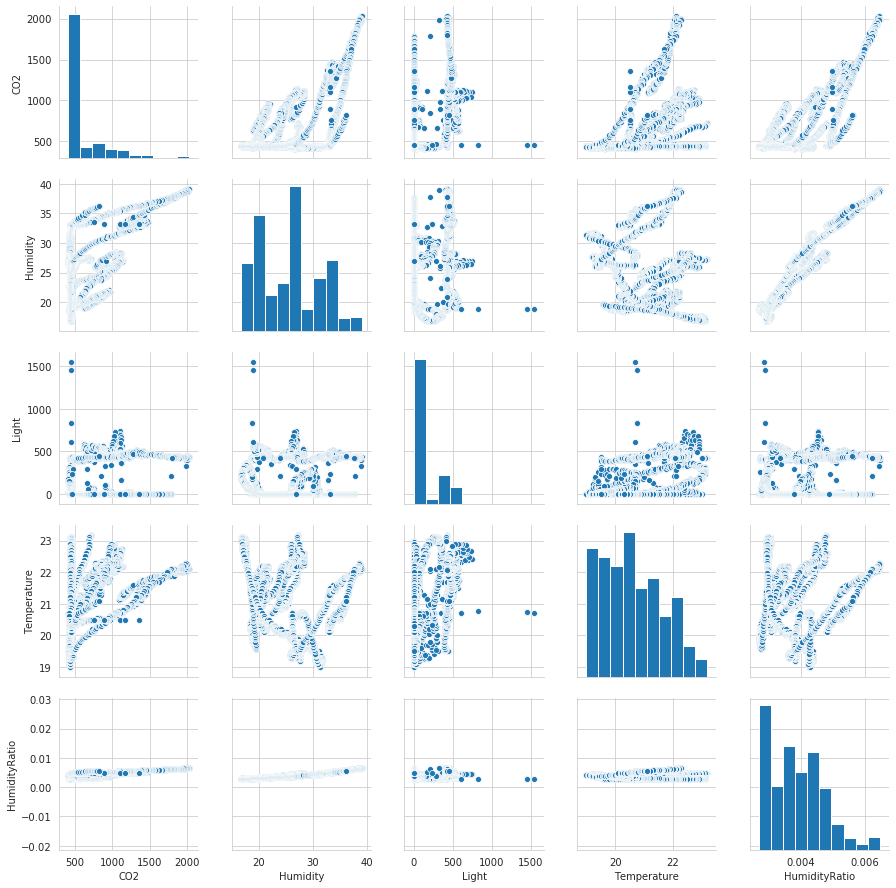

In [128]:
sns.pairplot(occupancy_df, palette='cubehelix')

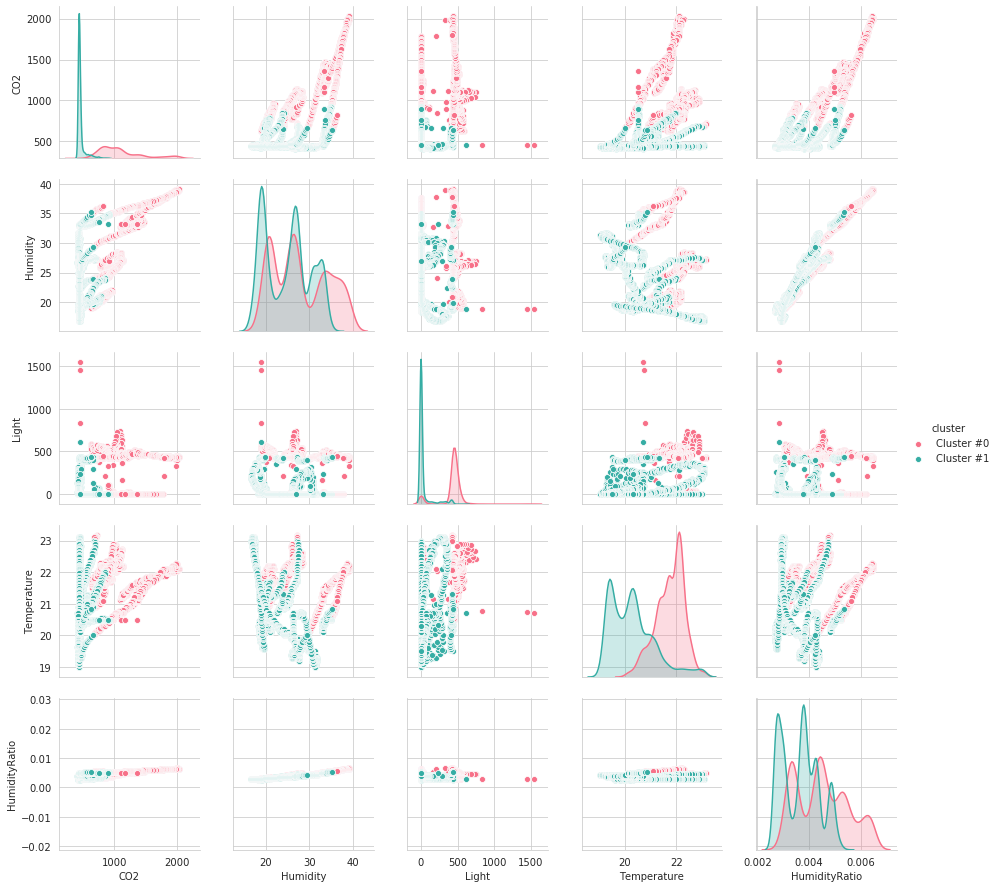

In [132]:
occupancy_clusters = k_means(occupancy_df.to_numpy(), 2, euclidean_distance)
occupancy_df = occupancy_df.assign(
    cluster=np.array([f'Cluster #{_}' for _ in range(2)])[occupancy_clusters])

sns.pairplot(occupancy_df, hue='cluster', palette='husl')

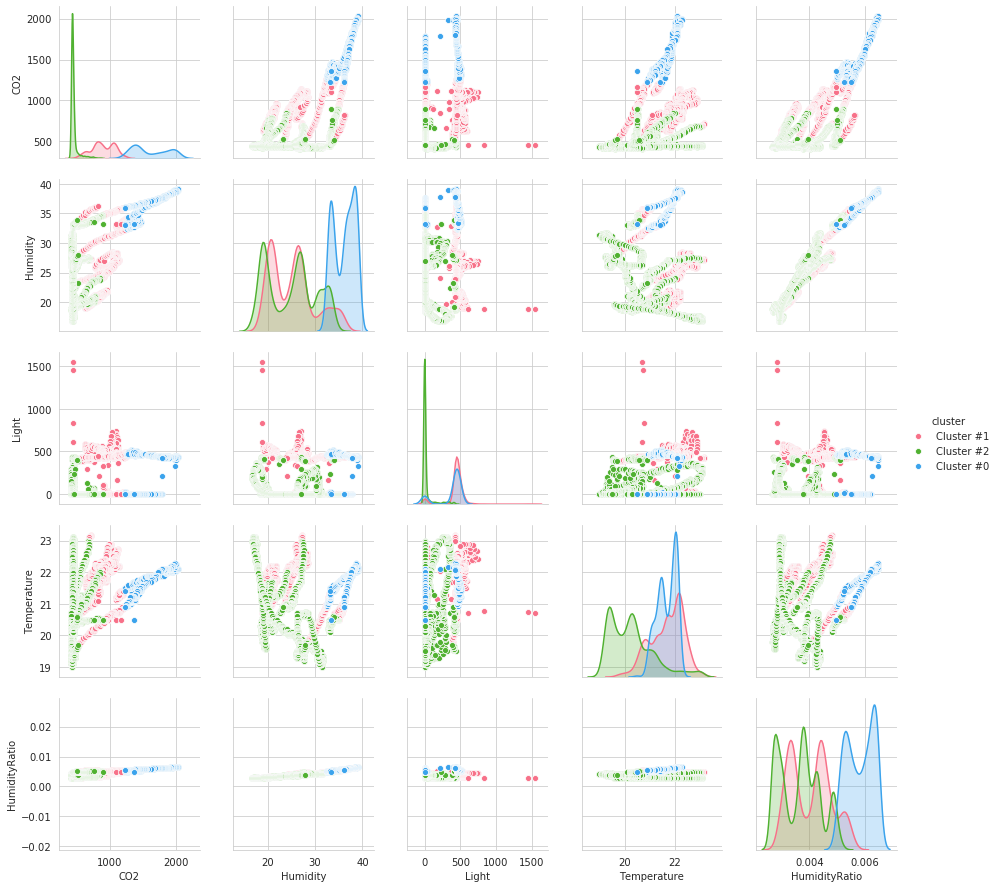

In [134]:
occupancy_clusters = k_means(occupancy_df.to_numpy(), 3, euclidean_distance)
occupancy_df = occupancy_df.assign(
    cluster=np.array([f'Cluster #{_}' for _ in range(3)])[occupancy_clusters])

sns.pairplot(occupancy_df, hue='cluster', palette='husl')

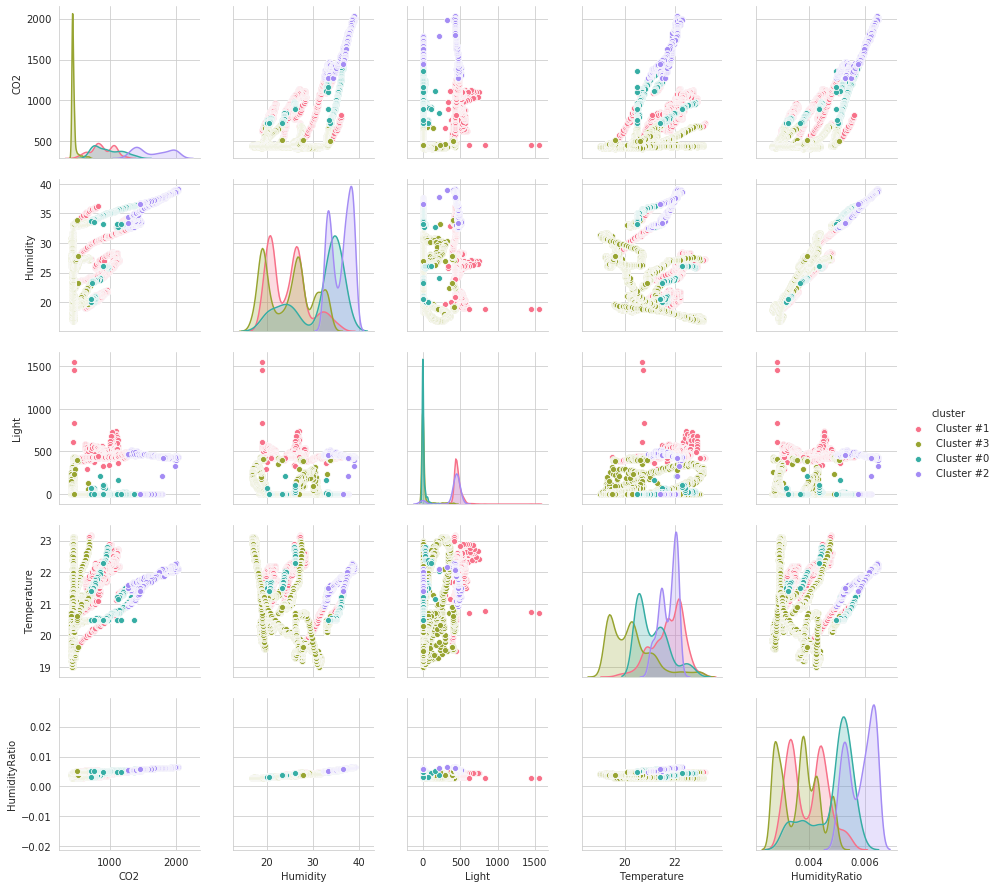

In [136]:
occupancy_clusters = k_means(occupancy_df.to_numpy(), 4, euclidean_distance)
occupancy_df = occupancy_df.assign(
    cluster=np.array([f'Cluster #{_}' for _ in range(4)])[occupancy_clusters])

sns.pairplot(occupancy_df, hue='cluster', palette='husl')

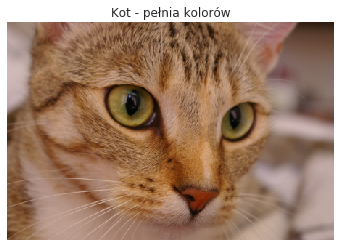

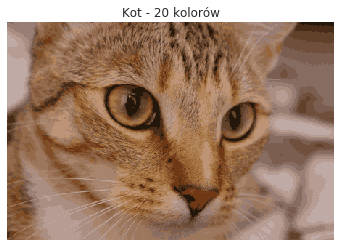

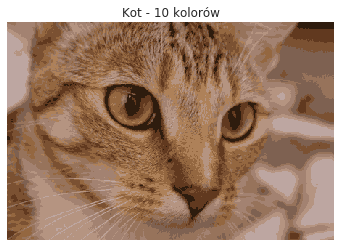

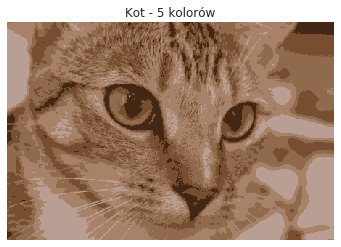

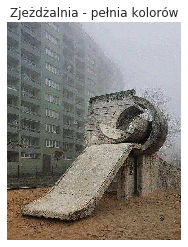

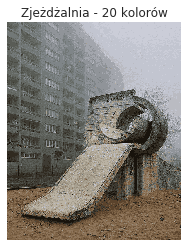

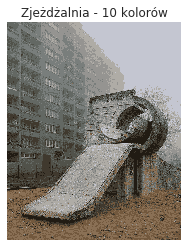

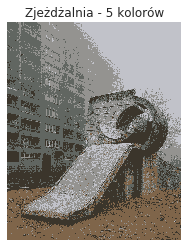

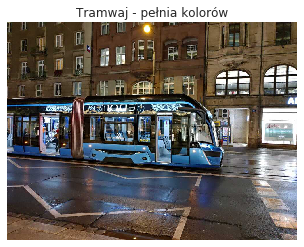

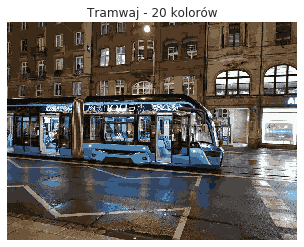

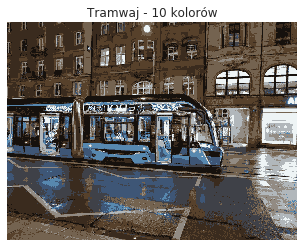

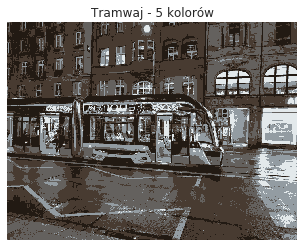

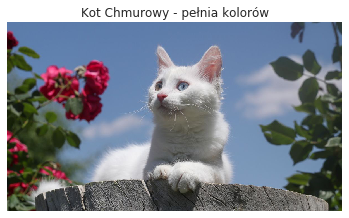

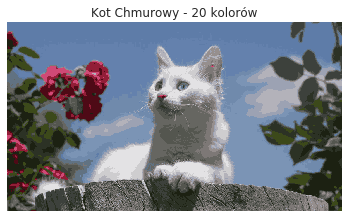

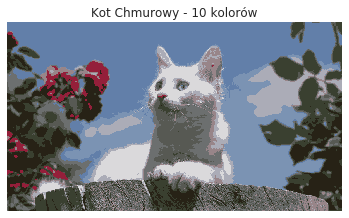

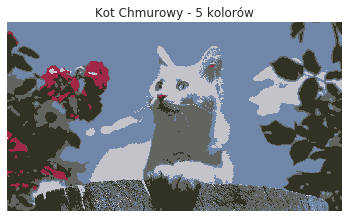

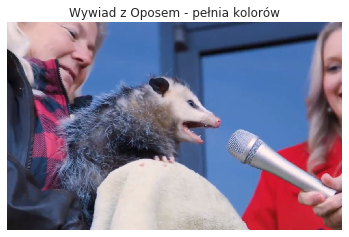

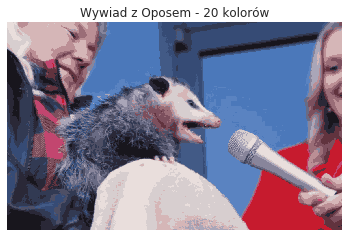

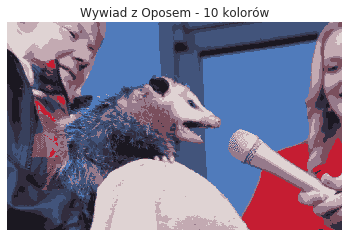

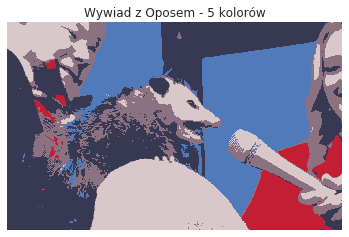

In [38]:
IMAGES = {
    'Kot': skimage.data.chelsea().astype(np.int32),
    'Zjeżdżalnia': plt.imread('img/zjezdzalnia.jpg').astype(np.int32),
    'Tramwaj': plt.imread('img/tramwaj2.jpg').astype(np.int32),
    'Kot Chmurowy': plt.imread('img/kotek.jpg').astype(np.int32),
    'Wywiad z Oposem': plt.imread('img/possum.jpg').astype(np.int32),
}

for k_img, v_img in IMAGES.items():
    x, y, _ = v_img.shape
    buffer = np.zeros((x * y, 3), dtype=np.int32)
    plt.axis('off')
    plt.imshow(v_img)
    plt.title(f'{k_img} - pełnia kolorów')
    plt.show()
    
    for K in [20, 10, 5]:
        color_groups, centroids = k_means(
            v_img.reshape(x*y, 3), K, euclidean_distance, return_centroids=True)
        for group_idx in range(K):
            buffer[color_groups == group_idx] = centroids[group_idx]
        plt.axis('off')
        plt.imshow(buffer.reshape((x, y, 3)))
        plt.title(f'{k_img} - {K} kolorów')
        plt.show()